# 1. Data preprocessing

## 1.1 File Consolidation

In [1]:
import os
import re
import glob
import pandas as pd

# Target companies, keep company names in Chinese as requested
companies = ["万科A", "比亚迪", "中国石油", "贵州茅台", "中国石化"]

# Locate all yearly files
pattern = "/Users/Zhuanz1/Downloads/网络新闻量化统计（按自然日）-*.xlsx"
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matched pattern: {pattern} (check your working directory)")

def extract_year(path: str):
    m = re.search(r"-(\d{4})\.xlsx$", os.path.basename(path))
    return int(m.group(1)) if m else None

# file columns
usecols = [
    "Scode", "Coname", "Date",
    "Newsnum_Title", "Newsnum_Cont",
    "Posnews_All", "Neunews_All", "Negnews_All",
    "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
]

# Read, clean, filter, and merge across files
dfs = []
for fp in files:
    df = pd.read_excel(fp, usecols=usecols, dtype={"Scode": str})

    # Drop the first "Chinese description/header" row 
    df = df[df["Coname"].notna()]
    df = df[(df["Coname"] != "公司简称") & (df["Scode"] != "股票代码")]

    # Parse date as datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].notna()]

    # Filter target companies
    df = df[df["Coname"].isin(companies)].copy()

    # Add year and source filename
    df["Year"] = extract_year(fp)
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df.sort_values(["Coname", "Date"]).reset_index(drop=True)

# Output file
out_path = "/Users/Zhuanz1/Downloads/news_data.xlsx"

with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    all_df.to_excel(writer, index=False, sheet_name="long")

    pivot = all_df.pivot_table(
        index="Date",
        columns="Coname",
        values=[
            "Newsnum_Title", "Newsnum_Cont",
            "Posnews_All", "Neunews_All", "Negnews_All",
            "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
        ],
        aggfunc="sum"
    )
    pivot.to_excel(writer, sheet_name="wide_pivot")

print(f"Merge completed: {out_path}")
print("Total rows:", len(all_df))
print("Years covered:", sorted(all_df["Year"].dropna().unique().tolist()))


Merge completed: /Users/Zhuanz1/Downloads/news_data.xlsx
Total rows: 21217
Years covered: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [2]:
base_dir = "/Users/Zhuanz1/Desktop/Thesis"
files = sorted(glob.glob(os.path.join(base_dir, "*price.xlsx")))
if not files:
    raise FileNotFoundError(f"No price files found in: {base_dir} (pattern: *price.xlsx)")

# Target stocks
code_to_name = {
    "000002": "万科A",
    "002594": "比亚迪",
    "601857": "中国石油",
    "600519": "贵州茅台",
    "600028": "中国石化",
}
target_codes = set(code_to_name.keys())

dfs = []
for fp in files:
    df = pd.read_excel(fp, sheet_name=0)

    # Keep only rows that look like real dates
    df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
    df = df[df["TradingDate"].notna()].copy()

    # Standardize code to 6-digit string
    df["Symbol"] = df["Symbol"].astype(str).str.extract(r"(\d{6})", expand=False)

    # Filter target companies
    df = df[df["Symbol"].isin(target_codes)].copy()

    # Add company name and year
    df["Coname"] = df["Symbol"].map(code_to_name)
    df["Year"] = df["TradingDate"].dt.year
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)

# Sort by company + year + date
merged = merged.sort_values(["Coname", "Year", "TradingDate"]).reset_index(drop=True)

# Output
out_path = os.path.join(base_dir, "price_data.xlsx")
merged.to_excel(out_path, index=False)

print("Merged rows:", len(merged))
print("Saved to:", out_path)
print("Companies:", merged["Coname"].unique().tolist())
print("Years:", sorted(merged["Year"].unique().tolist()))


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_54175/1331109773.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_54175/1331109773.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil

Merged rows: 13040
Saved to: /Users/Zhuanz1/Desktop/Thesis/price_data.xlsx
Companies: ['万科A', '中国石化', '中国石油', '比亚迪', '贵州茅台']
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [8]:
# Input files
input_files = [
    "/Users/Zhuanz1/Desktop/Thesis/price_data.xlsx",
    "/Users/Zhuanz1/Desktop/Thesis/news_data.xlsx",
]

# Chinese -> English mapping
name_map = {
    "万科A": "Vanke A",
    "中国石化": "Sinopec",
    "中国石油": "PetroChina",
    "比亚迪": "BYD",
    "贵州茅台": "Kweichow Moutai",
}

# Possible company-name columns
NAME_COL_CANDIDATES = ["Coname", "name", "公司", "公司简称", "证券简称"]

def find_name_cols(columns):
    return [c for c in NAME_COL_CANDIDATES if c in columns]

for fp in input_files:
    xls = pd.ExcelFile(fp)
    out_path = os.path.splitext(fp)[0] + "_EN.xlsx"

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for sheet in xls.sheet_names:
            df = pd.read_excel(fp, sheet_name=sheet)

            # Detect name columns in this sheet
            name_cols = find_name_cols(df.columns)

            # Replace in all detected name columns
            for col in name_cols:
                df[col] = df[col].astype(str).replace(name_map)

            df.to_excel(writer, sheet_name=sheet, index=False)

    print(f"Done: {out_path}")


Done: /Users/Zhuanz1/Desktop/Thesis/price_data_EN.xlsx
Done: /Users/Zhuanz1/Desktop/Thesis/news_data_EN.xlsx


In [12]:
import pandas as pd

# File paths
price_path = "/Users/Zhuanz1/Desktop/Thesis/price_data_EN.xlsx"
news_path  = "/Users/Zhuanz1/Desktop/Thesis/news_data_EN.xlsx"
out_path   = "/Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx"

# Read files
price = pd.read_excel(price_path)
news  = pd.read_excel(news_path)

# Convert Date to datetime
price["Date"] = pd.to_datetime(price["Date"], errors="coerce")
news["Date"]  = pd.to_datetime(news["Date"], errors="coerce")

# Shift news date forward by 1 day so that news on (t-1) matches price on t
news["Date"] = news["Date"] + pd.Timedelta(days=1)

# Merge
merged = pd.merge(price, news, on=["Scode", "Date"], how="left")

# Sort and save
merged = merged.sort_values(["Scode", "Date"])
merged.to_excel(out_path, index=False)

print("Saved to:", out_path)
print("Merged rows:", len(merged))


Saved to: /Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx
Merged rows: 13040


## 1.2 Indicator Calculation

### 1.2.1 Technical Indicators

In [13]:
import pandas as pd
import numpy as np

# Read files
df = pd.read_excel("/Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx")
df["Date"] = pd.to_datetime(df["Date"])
df["Scode"] = df["Scode"].astype(str).str.extract(r"(\d+)", expand=False)

df = df.sort_values(["Scode", "Date"]).reset_index(drop=True)

# Parameter: (High * Low)^a in PWHLD, a = 0.5 means square root
a = 0.5
# Small constant to avoid division by zero
gamma = 1e-12

def add_factors(g: pd.DataFrame) -> pd.DataFrame:
    g = g.copy()
    close = g["ClosePrice"]
    open_ = g["OpenPrice"]
    high = g["HighPrice"]
    low = g["LowPrice"]
    vol = g["Volume"]
    amt = g["Amount"]

    # r_t^(1) = ln(P_{t-1}) - ln(P_t)
    g["r1"] = np.log(close.shift(1)) - np.log(close)

    # Binary label (up = 1, down = 0)
    g["y_up_1d"] = (g["r1"] > 0).astype(int)

    # VA6DR = ((Close_t - Close_{t-6}) / Close_{t-6}) * Volume_t
    g["VA6DR"] = ((close - close.shift(6)) / close.shift(6)) * vol

    # UMF = (sum_{i=1..20} I(Close_{t-i} > Close_{t-i-1}) / 20) * 100
    up = (close.diff() > 0).astype(float)  # up[t] = I(Close_t > Close_{t-1})
    g["UMF"] = up.shift(1).rolling(20, min_periods=20).mean() * 100

    # PRM = (sum_{i=1..50}(High_{t-i}-Open_{t-i}) / sum_{i=1..50}(Open_{t-i}-Low_{t-i})) * 100
    num = (high - open_).shift(1).rolling(50, min_periods=50).sum()
    den = (open_ - low).shift(1).rolling(50, min_periods=50).sum()
    g["PRM"] = (num / den) * 100

    # PWHLD = (High_t*Low_t)^a - Amount_t/(Volume_t)
    g["PWHLD"] = (high * low) ** a - (amt / vol)

    # 20DAMA = (1/20) * sum_{i=1..20} Amount_{t-i}
    g["20DAMA"] = amt.shift(1).rolling(20, min_periods=20).mean()

    # 5DAMA = (1/5) * sum_{i=1..5} Amount_{t-i}
    g["5DAMA"] = amt.shift(1).rolling(5, min_periods=5).mean()

    # DPA = -1 if (High-Open)(Close-Low) < (Open-Low)(High-Close), else 0
    cond = (high - open_) * (close - low) < (open_ - low) * (high - close)
    g["DPA"] = np.where(cond, -1, 0).astype(int)

    # OR = Open_t / Close_{t-1} - 1
    g["OR"] = open_ / (close.shift(1) + gamma) - 1

    # STCPC = ( (1/6) * sum_{i=1..6} Close_{t-i} ) / Close_t
    g["STCPC"] = close.shift(1).rolling(6, min_periods=6).mean() / close

    # IPM = (Close_t - Open_t) / (High_t - Low_t + gamma)
    g["IPM"] = (close - open_) / (high - low + gamma)

    return g

out = df.groupby("Scode", group_keys=False).apply(add_factors)

# Save
out.to_excel("/Users/Zhuanz1/Desktop/Thesis/price_news_factors.xlsx", index=False)
print("done:", out.shape)


/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_54175/3203201331.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("Scode", group_keys=False).apply(add_factors)


done: (13040, 36)


In [14]:
import pandas as pd
import numpy as np

df = pd.read_excel("/Users/Zhuanz1/Desktop/Thesis/price_news_factors.xlsx")

for c in ["Volume", "Amount"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Drop rows where Volume or Amount is 0 
df = df[(df["Volume"] > 0) & (df["Amount"] > 0)].copy()

# Drop rows where all remaining numeric columns are 0
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

# Exclude Volume/Amount from the "all-zero row" check
num_cols_wo_va = [c for c in num_cols if c not in ["Volume", "Amount"]]

# Drop rows where all these numeric columns are 0
df = df.loc[~(df[num_cols_wo_va].fillna(0).eq(0).all(axis=1))].copy()

# Drop numeric columns that are entirely 0
zero_cols = [c for c in num_cols_wo_va if df[c].fillna(0).eq(0).all()]
df = df.drop(columns=zero_cols)

# Save
out_path = "/Users/Zhuanz1/Desktop/Thesis/price_news_factors_clean.xlsx"
df.to_excel(out_path, index=False)

print("Saved to:", out_path)
print("Rows after cleaning:", len(df))
print("Dropped all-zero columns:", zero_cols)


Saved to: /Users/Zhuanz1/Desktop/Thesis/price_news_factors_clean.xlsx
Rows after cleaning: 12025
Dropped all-zero columns: []


### 1.2.2 Sentiment Indicators

In [15]:
import numpy as np
import pandas as pd

eps = 1e-12

df = pd.read_excel("/Users/Zhuanz1/Desktop/Thesis/price_news_factors_clean.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

# ensure numeric
for c in ["Posnews_All","Neunews_All","Negnews_All","Newsnum_Cont"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

P = df["Posnews_All"]
U = df["Neunews_All"]
N = df["Negnews_All"]
T = P + U + N

df["sent_SB"]  = (P - N) / (T + eps)
df["sent_NEG"] = N / (T + eps)
df["sent_ATT"] = np.log1p(df["Newsnum_Cont"])
df["sent_HAS"] = (df["Newsnum_Cont"] > 0).astype(int)   # optional but recommended

out_path = "/Users/Zhuanz1/Desktop/Thesis/price_news_sentiment.xlsx"
df.to_excel(out_path, index=False)
print("Saved:", out_path)


Saved: /Users/Zhuanz1/Desktop/Thesis/price_news_sentiment.xlsx


# 2. Feature Engineering

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

path = "/Users/Zhuanz1/Desktop/Thesis/price_news_sentiment.xlsx"

df = pd.read_excel(path)

# Drop rows that contain any missing values
df = df.dropna()

# Save back to the same file
df.to_excel(path, index=False)

print("Done. Rows left:", len(df))
print(df.head(5))

Done. Rows left: 11529
        Date  Scode   Coname  OpenPrice  ClosePrice  HighPrice  LowPrice  \
0 2014-03-12      2  Vanke A    686.427     697.439    720.381   680.921   
1 2014-03-13      2  Vanke A    695.603     707.533    720.381   691.015   
2 2014-03-14      2  Vanke A    704.780     691.015    716.710   688.262   
3 2014-03-17      2  Vanke A    697.439     712.122    715.792   696.521   
4 2014-03-18      2  Vanke A    712.122     697.439    712.122   692.850   

      Volume        Amount  AvgPrice  ...        20DAMA         5DAMA  DPA  \
0  208987285  1.603159e+09   703.954  ...  8.389994e+08  1.163347e+09    0   
1  149235872  1.149904e+09   707.074  ...  8.876140e+08  1.403469e+09    0   
2  130310997  9.962134e+08   701.568  ...  9.137460e+08  1.253268e+09   -1   
3  117707900  9.082930e+08   708.176  ...  9.285072e+08  1.199770e+09    0   
4   84389956  6.426806e+08   698.907  ...  9.426385e+08  1.214016e+09   -1   

             OR     STCPC       IPM   sent_SB  sent

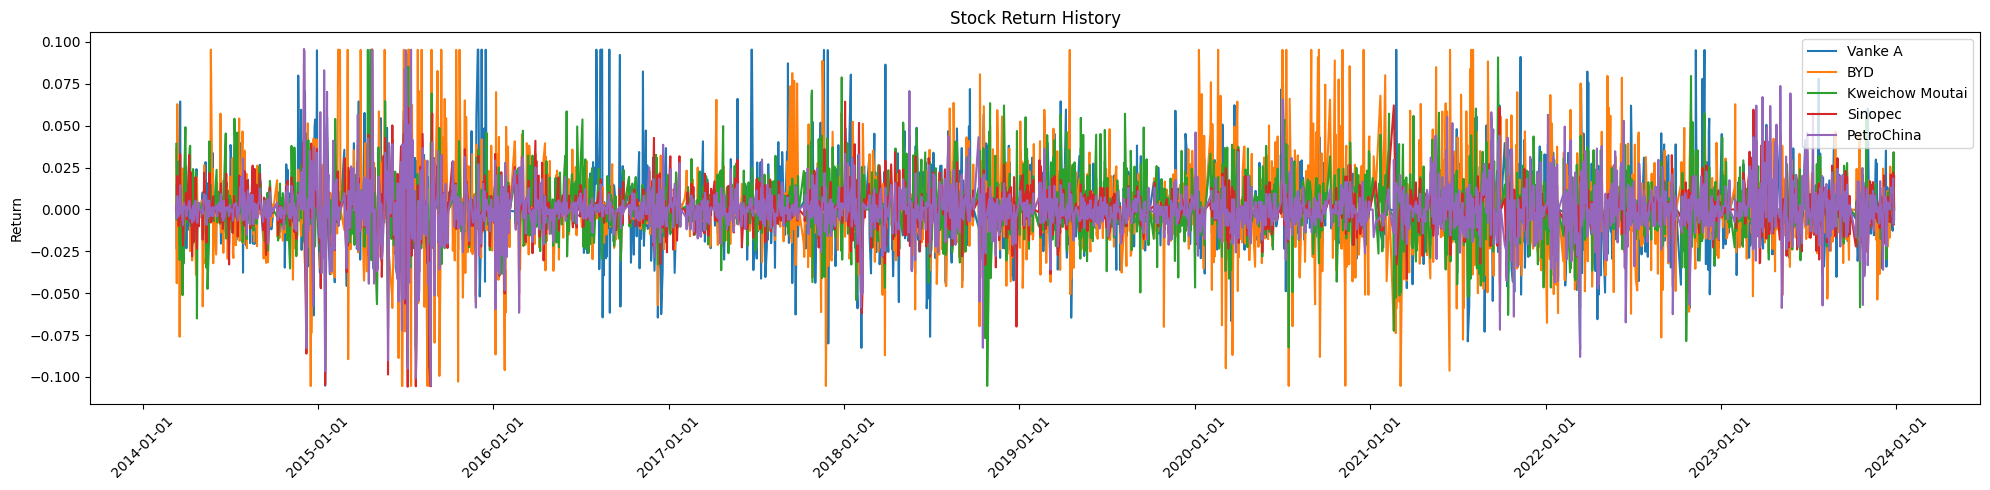

In [33]:
names = ["Vanke A", "BYD", "Kweichow Moutai","Sinopec","PetroChina"] 

fig, ax = plt.subplots(figsize=(20, 5))
for name in names:
    tmp = df[df["Coname"] == name].dropna(subset=["Date", "r1"]).sort_values("Date")
    ax.plot(tmp["Date"], tmp["r1"], label=name)

ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.set_title("Stock Return History")
ax.set_ylabel("Return")
plt.xticks(rotation=45)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [38]:
import torch
from torch.utils.data import TensorDataset

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Scode"] = df["Scode"].astype(str).str.extract(r"(\d+)", expand=False)
df = df.dropna(subset=["Date", "Scode", "y_up_1d"]).copy()

feature_cols = [
    "OpenPrice","ClosePrice","HighPrice","LowPrice",
    "Volume","ChangeRatio",
    "VA6DR","UMF","PRM","PWHLD","20DAMA","5DAMA","DPA","OR","STCPC","IPM",
    "sent_SB","sent_NEG","sent_ATT","sent_HAS"
]

# split by date 
TRAIN_END = pd.Timestamp("2020-12-31")
VAL_END   = pd.Timestamp("2021-12-31")

train_df = df[df["Date"] <= TRAIN_END].copy()
val_df   = df[(df["Date"] > TRAIN_END) & (df["Date"] <= VAL_END)].copy()
test_df  = df[df["Date"] > VAL_END].copy()

In [43]:
from sklearn.preprocessing import StandardScaler

# Ensure all feature columns are numeric
for c in feature_cols:
    train_df[c] = pd.to_numeric(train_df[c], errors="coerce")
    val_df[c]   = pd.to_numeric(val_df[c], errors="coerce")
    test_df[c]  = pd.to_numeric(test_df[c], errors="coerce")

# Handle inf / -inf
# Infinity appears when the high and low prices are the same; we then fill these values with 0
for d in [train_df, val_df, test_df]:
    d[feature_cols] = d[feature_cols].replace([np.inf, -np.inf], np.nan)

# Fill missing/invalid values with 0
train_df[feature_cols] = train_df[feature_cols].fillna(0)
val_df[feature_cols]   = val_df[feature_cols].fillna(0)
test_df[feature_cols]  = test_df[feature_cols].fillna(0)

# Standardize 
scaler = StandardScaler()
scaler.fit(train_df[feature_cols].values)

train_df[feature_cols] = scaler.transform(train_df[feature_cols].values)
val_df[feature_cols]   = scaler.transform(val_df[feature_cols].values)
test_df[feature_cols]  = scaler.transform(test_df[feature_cols].values)


In [44]:
# build windows 
def make_windows(df_part, feature_cols, lag):
    X_list, y_list, scode_list, date_list = [], [], [], []

    for scode, g in df_part.groupby("Scode"):
        g = g.sort_values("Date").reset_index(drop=True)
        if len(g) < lag:
            continue

        Xg = g[feature_cols].values.astype(np.float32)  
        yg = g["y_up_1d"].values.astype(np.float32)      
        dg = g["Date"].values 
        
        for end in range(lag - 1, len(g)):
            start = end - lag + 1
            X_list.append(Xg[start:end + 1])           
            y_list.append(yg[end])                     
            scode_list.append(str(scode))             
            date_list.append(dg[end])                 

    X = torch.tensor(np.stack(X_list), dtype=torch.float32)  
    y = torch.tensor(np.array(y_list), dtype=torch.float32)
    
    # store scode/date as tensors too 
    scode_int = torch.tensor([int(s) for s in scode_list], dtype=torch.long)
    date_int  = torch.tensor(pd.to_datetime(date_list).astype("int64"), dtype=torch.long) 

    return TensorDataset(X, y)

lag = 5
train_set = make_windows(train_df, feature_cols, lag)
val_set   = make_windows(val_df, feature_cols, lag)
test_set  = make_windows(test_df, feature_cols, lag)

print("Train/Val/Test:", len(train_set), len(val_set), len(test_set))
print("One sample:", train_set[0][0].shape, train_set[0][1].shape) 


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Train/Val/Test: 8040 1077 2352
One sample: torch.Size([5, 20]) torch.Size([])


In [45]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

# 3. Intra-modal feature extraction

## 3.1 Price modality: the LSTM encoder extracts temporal features

In [46]:
import torch.nn as nn

price_cols = [
    "OpenPrice","ClosePrice","HighPrice","LowPrice",
    "Volume","ChangeRatio",
    "VA6DR","UMF","PRM","PWHLD","20DAMA","5DAMA","DPA","OR","STCPC","IPM",
]

news_cols = ["sent_SB","sent_NEG","sent_ATT","sent_HAS"]

n_price = len(price_cols)
n_news  = len(news_cols)

class PriceLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, x_price):
        """
        x_price: (B, L, D_price)
        return:  (B, hidden_dim)
        """
        out, (h_n, c_n) = self.lstm(x_price)
        # take the last layer's hidden state at the last time step
        h_price = h_n[-1]   # (B, hidden_dim)
        return h_price

## 3.2 News modality: the MLP encoder extracts a nonlinear sentiment representation

In [47]:
class NewsMLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, out_dim=32, dropout=0.1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim),
            nn.ReLU()
        )

    def forward(self, x_news):
        """
        x_news: (B, L, D_news)
        return: (B, out_dim)
        """
        B, L, D = x_news.shape
        z = self.mlp(x_news.reshape(B * L, D))     # (B*L, out_dim)
        z = z.reshape(B, L, -1)                   # (B, L, out_dim)
        h_news = z.mean(dim=1)                    # (B, out_dim)  mean pooling
        return h_news